In [188]:
import pandas as pd
import numpy as np
import ramacovid as rc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import tensorflow as tf
#import tensorflow_addons as tfa
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Model
from keras.layers import Input, Reshape, Dropout, BatchNormalization
from keras.layers.merge import Concatenate
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback
from tqdm import tqdm
#-----------------------------------------------------------------------------
# Define custom loss functions for regression in Keras 
#-----------------------------------------------------------------------------

# root mean squared error (rmse) for regression
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# mean squared error (mse) for regression
def mse(y_true, y_pred):
    from keras import backend
    return backend.mean(backend.square(y_pred - y_true), axis=-1)

# coefficient of determination (R^2) for regression
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

def r_square_loss(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return 1 - ( 1 - SS_res/(SS_tot + K.epsilon()))

In [2]:
PATH = ""

In [723]:
R = rc.ramacovid(path=PATH)

In [724]:
#To get the recent incidence
pro = R.get_incidence(url = "https://covid19.th-stat.com/api/open/cases")

requests code : 200


In [15]:
#Prepare data
df = pd.read_csv("30Apr.csv", index_col="Confirm Date")
df.drop('ProvinceThai', inplace=True)
df_train = df.iloc[:-25,:]
df_test = df.iloc[-25:-4,:]
df_pop = df.iloc[-4:,:]
df_train = df_train.astype('float')
df_test = df_test.astype('float')

### Model

In [214]:
n_steps = 7
n_features = 1
# define model
model1_input = Input(shape=(n_steps, n_features), dtype='float32')
model1 = Conv1D(filters=64, kernel_size=2, activation='relu', strides=1)(model1_input)
model1 = MaxPooling1D(pool_size=2)(model1)
model1 = Dropout(0.1)(model1)
model1 = BatchNormalization()(model1)

model1 = Conv1D(filters=32, kernel_size=2, activation='relu', strides=1)(model1)
model1 = MaxPooling1D(pool_size=2)(model1)
model1 = Dropout(0.3)(model1)
model1 = BatchNormalization()(model1)

'''
model1 = Conv1D(filters=16, kernel_size=2, activation='relu', strides=1)(model1)
model1 = MaxPooling1D(pool_size=2)(model1)
model1 = Dropout(0.1)(model1)
model1 = BatchNormalization()(model1)
'''
model1 = Flatten()(model1)




#Add Feature
model2_input = Input(shape=(1,), dtype='float32')
model2 = Reshape((1,))(model2_input)

#Add Pop
model3_input = Input(shape=(4,1), dtype='float32')
model3 = Flatten()(model3_input)

merge2_3 = Concatenate(axis=-1)([model2, model3])
merge1_23 = Concatenate(axis=-1)([model1, merge2_3])
dense = Dense(50, activation='relu')(merge1_23)
dense = Dropout(0.3)(dense)
dense = Dense(8, activation='relu')(dense)
dense = Dropout(0.3)(dense)
output = Dense(1)(dense)



model = Model(inputs=[model1_input, model2_input, model3_input], outputs=output )
model.summary()
# compile regression model loss should be mean_squared_error //
model.compile(optimizer="Nadam", loss="mean_squared_error", metrics=["mean_squared_error", rmse, r_square])
# enable early stopping based on mean_squared_error
earlystopping=EarlyStopping(monitor="mean_squared_error", patience=8, mode='auto')

# initialize tqdm callback with default parameters
#tqdm_callback = tfa.callbacks.TQDMProgressBar()


Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           (None, 7, 1)         0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 6, 64)        192         input_45[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_27 (MaxPooling1D) (None, 3, 64)        0           conv1d_33[0][0]                  
__________________________________________________________________________________________________
dropout_42 (Dropout)            (None, 3, 64)        0           max_pooling1d_27[0][0]           
___________________________________________________________________________________________

### Training Function

In [215]:
def split_sequence(df, n_steps, df_pop):
    R = []
    init_province = 65 #For use to extended window validation
    pbar = tqdm(total=len(df.columns)-init_province)
    while init_province < len(df.columns):
        X_train, y_train, Mob, X_val, y_val, Mob_val, Pop , Pop_val = list(), list(), list(), list(), list(), list(), list(), list()
        for province in df.columns[1:init_province]:  
            sequence = df[province].values
            for i in range(len(sequence)):
                # find the end of this pattern
                end_ix = i + n_steps
                # check if we are beyond the sequence
                if end_ix > len(sequence)-1:
                    break
                # gather input and outpusequence[i:end_ix]t parts of the pattern
                seq_x = sequence[i:end_ix]
                seq_y = (sequence[end_ix]/(sequence[i]+1))
                X_train.append(seq_x)
                y_train.append(seq_y)
                Mob.append(df['walking'].values[i])
                Pop.append(df_pop[province].values)
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        Pop = np.array(Pop)       
        Mob = np.array(Mob)
       
        
        #Validation
        province = df.iloc[1:,init_province:init_province+1].columns
        sequence = df.iloc[1:,init_province].values
        for i in range(len(sequence)):
            # find the end of this pattern
            end_ix = i + n_steps
            # check if we are beyond the sequence
            if end_ix > len(sequence)-1:
                break
            # gather input and output parts of the pattern
            seq_x, seq_y = sequence[i:end_ix], (sequence[end_ix]/(sequence[i]+1))
            X_val.append(seq_x)
            y_val.append(seq_y)
            Mob_val.append(df['walking'].values[i])
            Pop_val.append(df_pop[province].values)
            
        X_val = np.array(X_val)
        y_val = np.array(y_val)
        Mob_val = np.array(Mob_val)
        Pop_val = np.array(Pop_val)
        
        #Reshape to fit in the model
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))
        
        X_val = X_val.reshape((X_val.shape[0], X_val.shape[1],1))
        Pop = Pop.reshape((Pop.shape[0], Pop.shape[1],1))
        Pop_val = Pop_val.reshape((Pop_val.shape[0], Pop_val.shape[1],1))
        print(f'X_train:{X_train.shape}, y_train:{y_train.shape}, Pop:{Pop.shape}, Mob:{Mob.shape}')
        print(f'X_val:{X_val.shape}, y_val:{y_val.shape}, Pop_val:{Pop_val.shape}, Mob:{Mob_val.shape}')
        
        #Fit the model
        result = model.fit([X_train,Mob,Pop], y_train, 
                           epochs=50, batch_size=64, 
                           validation_data=([X_val,Mob_val,Pop_val], y_val), 
                           callbacks=[earlystopping],
                          use_multiprocessing=True)
        init_province +=1
        pbar.update()  
    pbar.close()
    return result, model

In [ ]:
n_steps = 7
res, mod = split_sequence(df_train,n_steps, df_pop)

In [ ]:
res.history['val_rmse']

### Test with test set

In [206]:
def test_prep(df,n_steps,df_pop):
    X_test, y_test, Mob ,Pop= list(), list(), list(), list()
    for province in df.columns[1:]:  
        sequence = df[province].values  
        for i in range(1,(len(sequence)-5)):
            # find the end of this pattern
            end_ix = i + n_steps
            # check if we are beyond the sequence
            if end_ix > len(sequence)-1:
                break
            # gather input and output parts of the pattern
            seq_x, seq_y = sequence[i:end_ix], (sequence[end_ix]/(sequence[i]+1))
            X_test.append(seq_x)
            y_test.append(seq_y)
            Mob.append(df['walking'].values[i])
            Pop.append(df_pop[province].values)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    Mob = np.array(Mob)
    Pop = np.array(Pop)
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    Pop = Pop.reshape((Pop.shape[0], Pop.shape[1], 1))
    return X_test,y_test, Mob, Pop

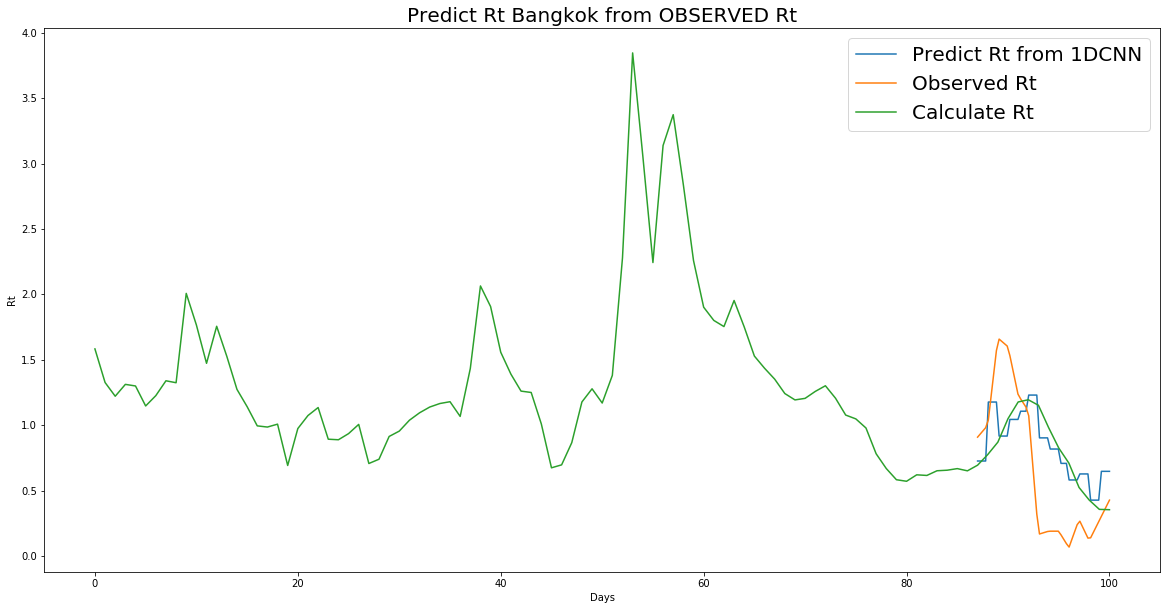

In [296]:
X_test,y_test,Mob,Pop = test_prep(df_test.iloc[:,[0,2]],7,df_pop)
y_pred = model.predict([X_test,Mob,Pop])
plt.figure(figsize=(20,10))

from scipy.interpolate import make_interp_spline, BSpline

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(87,100)  
spl = make_interp_spline(range(87,100), y_pred, k=0)
pred_smooth = spl(xnew)
plt.plot(xnew,pred_smooth,label="Predict Rt from 1DCNN")
spl = make_interp_spline(range(87,100), y_test, k=1)
test_smooth = spl(xnew)
plt.plot(xnew,test_smooth, label="Observed Rt")
res.history['val_rmse']
plt.plot(rdaily.index,rdaily.Bangkok, label="Calculate Rt")
plt.xlabel("Days")
plt.ylabel("Rt")
plt.legend(prop={'size': 20})
plt.title("Predict Rt Bangkok from OBSERVED Rt", fontsize=20)
plt.show()

In [224]:
rdaily = pd.read_csv("rdaily.csv")

In [228]:
rdaily = rdaily[['ConfirmDate','Bangkok']]

In [285]:
pd.DataFrame(data={'Rt_estim':rdaily.Bangkok.tail(13) , 'Rt_Predict':y_pred.ravel()})

,Rt_estim,Rt_Predict
88,0.775936,0.726728
89,0.871041,1.177531
90,1.050662,0.917511
91,1.178039,1.044525
92,1.194883,1.107352
93,1.152600,1.230698
94,0.982239,0.903599
95,0.826392,0.818333
96,0.710492,0.708639
97,0.524627,0.581920


### Evaluate Learning

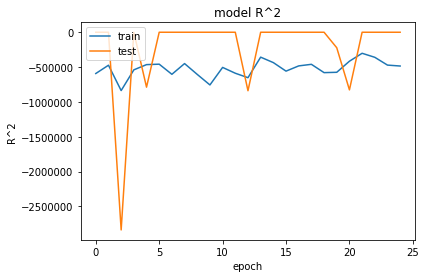

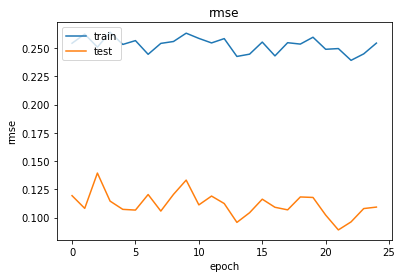

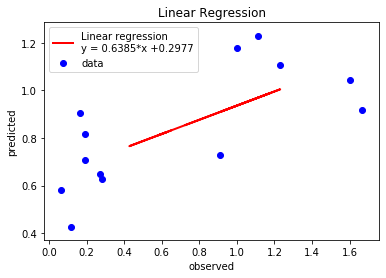

In [297]:
#-----------------------------------------------------------------------------
# Plot learning curves including R^2 and RMSE
#-----------------------------------------------------------------------------
result = res
# plot training curve for R^2 (beware of scale, starts very low negative)
plt.plot(result.history['val_r_square'])
plt.plot(result.history['r_square'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
           
# plot training curve for rmse
plt.plot(result.history['rmse'])
plt.plot(result.history['val_rmse'])
plt.title('rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# print the linear regression and display datapoints
from sklearn.linear_model import LinearRegression  
regressor = LinearRegression()  
regressor.fit(y_test.reshape(-1,1), y_pred)  
y_fit = regressor.predict(y_pred) 

reg_intercept = round(regressor.intercept_[0],4)
reg_coef = round(regressor.coef_.flatten()[0],4)
reg_label = "y = " + str(reg_intercept) + "*x +" + str(reg_coef)

plt.scatter(y_test, y_pred, color='blue', label= 'data')
plt.plot(y_pred, y_fit, color='red', linewidth=2, label = 'Linear regression\n'+reg_label) 
plt.title('Linear Regression')
plt.legend()
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()

In [298]:
import sklearn.metrics, math
print("\n")
print("Mean absolute error (MAE):      %f" % sklearn.metrics.mean_absolute_error(y_test,y_pred))
print("Mean squared error (MSE):       %f" % sklearn.metrics.mean_squared_error(y_test,y_pred))
print("Root mean squared error (RMSE): %f" % math.sqrt(sklearn.metrics.mean_squared_error(y_test,y_pred)))
print("R square (R^2):                 %f" % sklearn.metrics.r2_score(y_test,y_pred))



Mean absolute error (MAE):      0.410858
Mean squared error (MSE):       0.215044
Root mean squared error (RMSE): 0.463729
R square (R^2):                 0.338730


### Save model

In [400]:
model.save("covidCNN.h5")

### Load Model

In [ ]:
from keras.models import load_model
 
# load model
model = load_model('model.h5')
# summarize model.
model.summary()

## Plot graph

In [320]:
incidence = df.iloc[:-4,1:].astype('int').sum(axis=1).reset_index()[[0]]
rt = pd.read_csv("rdaily.csv")

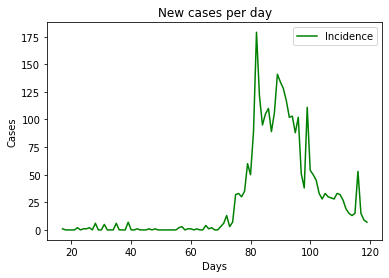

In [395]:
plt.plot(range(17,17+len(incidence)), incidence.values, color='green', label = 'Incidence')
plt.xlim = (0,140)
plt.xlabel("Days")
plt.ylabel("Cases")
plt.title("New cases per day")
plt.legend()
plt.savefig("incidence.png")

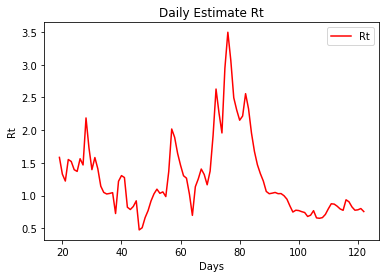

In [396]:
plt.plot(range(19,19+len(rt.Thailand)), rt.Thailand.values, color='red', label = "Rt", )
plt.xlim = (0,140)
plt.xlabel("Days")
plt.ylabel("Rt")
plt.title("Daily Estimate Rt")
plt.legend()
plt.savefig("Rt.png")

In [353]:
mobi = pd.read_csv("applemobilitytrends-2020-04-28.csv")
mobi = mobi.loc[mobi.region == 'Thailand'].drop(columns=['geo_type','region','alternative_name'])
mobi = mobi.set_index("transportation_type")
mobi = mobi.T

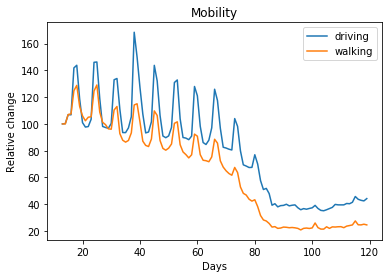

In [399]:
plt.plot(range(13,13+len(mobi.driving)), mobi.driving.values, label = 'driving')
plt.plot(range(13,13+len(mobi.walking)), mobi.walking.values, label = 'walking')
plt.xlabel("Days")
plt.ylabel("Relative change")
plt.title("Mobility")
plt.xlim = (0,140)
plt.legend()
plt.savefig("mobility.png")